# Морфология 2
В данном ноутбуке находится задание на триграммы и словарь. В качестве текста будем использовать томик войны и мира: https://goo.gl/qcVTLE 

Для начала напомним некоторые полезные инструменты на питоне

## 1. Инструменты

### 1.1. Регулярные выражения
Исчерпывающий пост https://habr.com/ru/post/349860/

In [1]:
import re

# С помощью рег. выражения можно искать, заменять и сентезировать строки по шаблонам
# Парочка простых примеров
numbers = re.findall(r'\d+', r'There is some numbers: 49 and 432')
print('Находим числа в строке: ', numbers)

print('Простенький токенизатор: ', re.sub('[,\.?!]',' ','How, to? split. text!').split())

print('Еще один токенизатор: ', re.split(r'\W+', 'How, to? split. text! Again'))

# в качестве тренировки придумайте свой токенизатор в случае, когда из текста нужно получить только русские слова.

Находим числа в строке:  ['49', '432']
Простенький токенизатор:  ['How', 'to', 'split', 'text']
Еще один токенизатор:  ['How', 'to', 'split', 'text', 'Again']


### 1.2. Чтение файлов
Чтобы не мучится самим с кодировками, приведем способ чтения файла корпуса.

In [2]:
!ls

 box_filter_2.py		  'Morphology 2.ipynb'	 one.jpg	 wp.txt
 Morphology1_AstakhovAnton.ipynb   niki4.png		 Timka_1.ipynb


In [3]:
text_file_path = 'wp.txt'

In [4]:
import io
wordlilist = None
with io.open(text_file_path, "r") as text_file:
    text = text_file.read()
    wordlist = re.sub('[^а-я]',' ', text.lower()).split()

### 1.3. ООП
В питоне можно создавать свои классы, скорее всего нам понадобится класс для хранения бора

In [5]:
class Node:
    def __init__(self, data):
        '''
        Simple constructor without params
        '''
        self.data = data
        self.children = []
        self.finish = False
        self.counter = 1

        
    def add_word(self, word):
        node = self
        
        for elem in word:
            found = False
            for child in node.children:
                if child.data == elem:
                    child.counter += 1
                    node = child
                    found = True
                    break

            if not found:
                new_node = Node(elem)
                node.children.append(new_node)
                node = new_node
                
        node.finish = True
        
    def is_in(self, word):
        node = self
        
        for elem in word:
            found = False
            for child in node.children:
                if child.data == elem:
                    node = child
                    found = True
                    break
                    
            if not found:
                return False
            
        if node.finish:
            return True
        else:
            return False

In [6]:
bor = Node('#')
for word in wordlist:
    bor.add_word(word)

In [7]:
bor.is_in('лев')

True

In [8]:
bor.is_in('лапап')

False

In [9]:
wordlist_new = ['##' + word + '##' for word in wordlist]

In [10]:
wordlist_new[:6]

['##лев##', '##николаевич##', '##толстой##', '##война##', '##и##', '##мир##']

### 1.4. pyplot
Довольно часто приходится построить какие-нибудт графики и гистограммы для изучения данных, с которыми придется работать. Для этого в питоне есть удобнейший модуль для этого - pyplot. Туториал: https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html

In [11]:
#!pip install matplotlib # Установка модуля
import matplotlib.pyplot as plt
# команда чтобы картинки рисовались прямо в ноутбуке
%matplotlib inline 

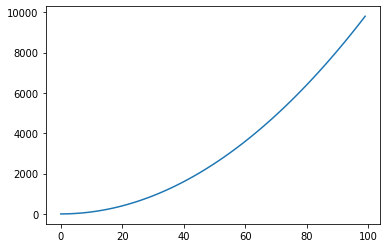

In [12]:
# Посмотрим на график функции x^2
data = [i * i for i in range(100)]
plt.plot(data)

(array([32., 13., 10.,  8.,  8.,  6.,  6.,  6.,  5.,  6.]),
 array([   0. ,  980.1, 1960.2, 2940.3, 3920.4, 4900.5, 5880.6, 6860.7,
        7840.8, 8820.9, 9801. ]),
 <a list of 10 Patch objects>)

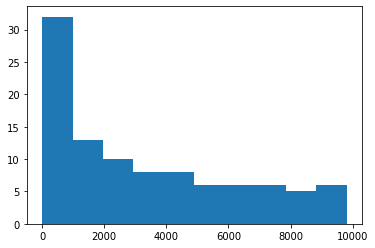

In [13]:
# и распределение по значениям
plt.hist(data)

Также полезная команда для подсчета времения выполнеия в ячейке

In [14]:
%%time
res = 0
for i in range(int(1e8)):
    res += 1

CPU times: user 10.4 s, sys: 3.13 ms, total: 10.4 s
Wall time: 10.4 s


## 2. Задание
Собственно теперь нам потребуется написать подсчет триграмм и бор для словаря, чтобы реализовать простенькую систему исправления ошибок.

### 2.1. Триграммы
Для начала получим словарь триграмма - её кол-во в тексте, не забывая о начале и конце слова.

Далее можно построить гистограмму на кол-во вхождений триграмм, и посмотреть самые частые и какая частота у каких-нибудь заведомо странных, например: 'чгк', 'шкя' и подобные. Из полученных данных придумать эвристику, как считать слово с опечаткой. Проверить эвристику по словарю.

In [15]:
from nltk.util import ngrams
import numpy as np
import collections

In [16]:
def corpus_trigrams(word_list):
    '''returns trigrams count dictionary'''
    
    let_3 = []
    for i in range(len(word_list)):
        for elem in ngrams(word_list[i], 3):
            let_3.append(elem)
    print(let_3)
    
    c = collections.Counter() 
    for i in range(len(let_3)):
        c[let_3[i]] += 1
    
    return c

In [17]:
my_dict = corpus_trigrams(wordlist_new)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
# Кол-во триграмм
num_tri = 0
for elem in my_dict:
    num_tri += my_dict[elem]
num_tri

746926

In [19]:
import matplotlib.pyplot as plt

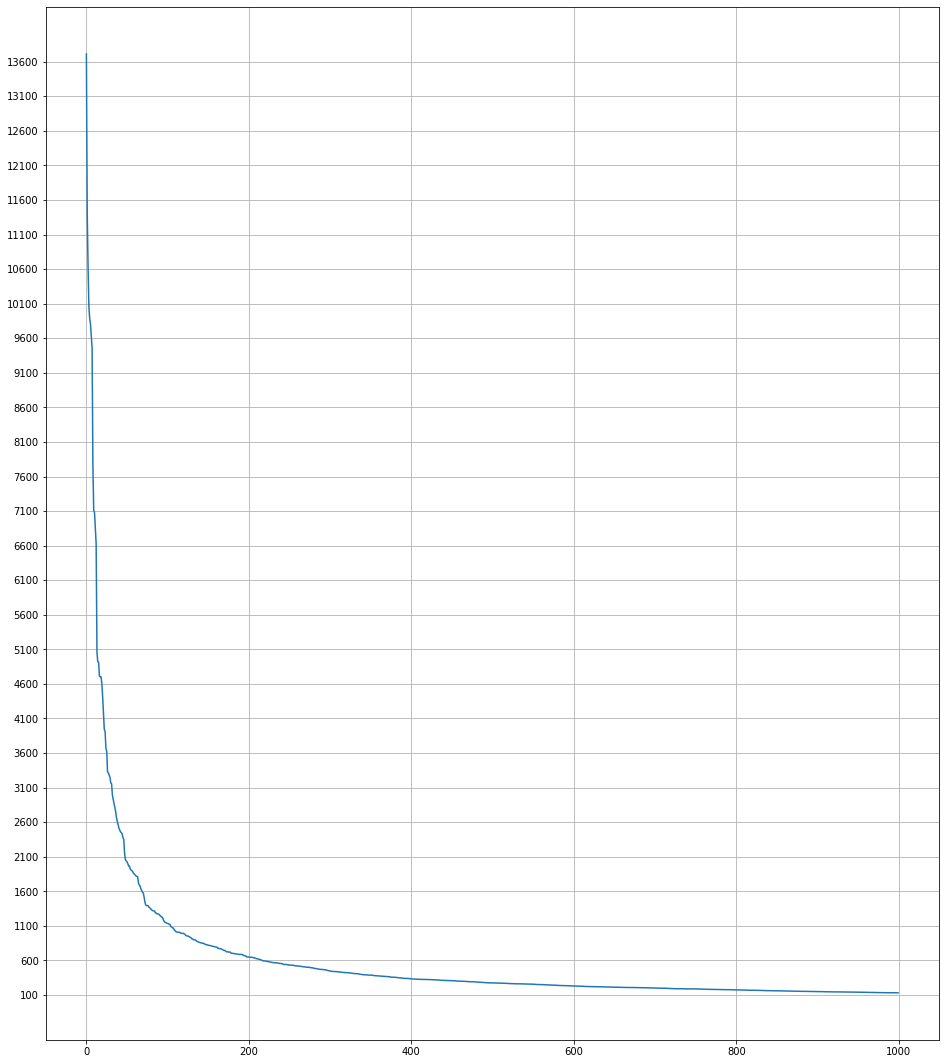

In [20]:
plt.figure(figsize=(16, 19))
plt.plot([elem[1] for elem in my_dict.most_common(1000)])
plt.yticks(range(100, 14000, 500))
plt.grid(True)
plt.show()

In [21]:
def is_error(word):
    '''is the word with mistake
    return place of the error'''
    word = '##' + word + '##'
    for i, elem in enumerate(ngrams(word, 3)):
        if my_dict[elem] <= 50:
            return True
    
    return False
        

In [22]:
is_error('лев')

False

### 2.2. Бор
Далее построим бор, с помощью которого будем искать исправления опечатки в слове. Пока только в случае замены и удаления в конце (Если есть желание, то можно и для всех случаев). Также сравнить по времени с поиском в случае замены в исходном слове последних двух символов и поиске в словаре.

In [23]:
def levenshtein(seq1, seq2):
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros((size_x, size_y))
    for x in range(size_x):
        matrix[x, 0] = x
    for y in range(size_y):
        matrix[0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x - 1] == seq2[y - 1]:
                matrix [x,y] = min(
                    matrix[x - 1, y] + 1,
                    matrix[x - 1, y - 1],
                    matrix[x, y - 1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x - 1, y] + 1,
                    matrix[x - 1, y - 1] + 1,
                    matrix[x, y - 1] + 1
                )
    #print (matrix)
    return (matrix[size_x - 1, size_y - 1])

In [24]:
levenshtein('корова', 'карова')

1.0

In [25]:
alpha_rus = set('а, б, в, г, д, е, ё, ж, з, и, й, к, л, м, н, о, п, р, с, т, у, ф, х, ц, ч, ш, щ, ъ, ы, ь, э, ю, я'.split(', '))

In [128]:
import copy
def correct_word(word):
    '''returns most similar word from dictionary'''

    if not is_error(word):
        return word
    
    global found, found_word
    found = False
    found_word = ''
    
    create(bor, 0, '#' + word)
    
    if not found:
        return word
    else:
        return found_word[1:]
    
def create(node, pos, word, new_word='', change=0):
    global found, found_word 
    if found:
        return
    
    new_word = copy.copy(new_word + node.data)
    if word[pos] != node.data:
        change += 1
        if change > 2:
            return
    
    if node.finish:
        if pos == len(word) - 2 and change < 2:
            found = True
            found_word = copy.copy(new_word)
        if pos == len(word) - 1:
            found = True
            found_word = copy.copy(new_word)
            
    if pos == len(word) - 1:
        return
    
    
    for child in node.children:
        if child.counter > 1:
            create(child, pos + 1, word, new_word, change)
    
def second(elem):
    return elem[1]
    
def correct_word_naive(word):
    '''correct word using generation'''
    if not is_error(word):
        return word
    
    global cand
    cand = []
    
    create_naive(0, word)
    cand.sort(key = second)
    #print(cand)
    for elem in cand:
        if bor.is_in(elem[0]):
            return elem[0]
        
    return word
    
    
def create_naive(pos, word, new_word=''):
    if levenshtein(word[:pos + 1], new_word) > 1:
        #print(new_word)
        return
    
    global cand
    
    if pos == len(word):
        cand.append((copy.copy(new_word), levenshtein(word, new_word)))
        return
    
    for elem in alpha_rus:
        create_naive(pos + 1, word, new_word + elem)
    

In [97]:
correct_word('кйкова')

'каков'

In [98]:
correct_word('кабан')

'какая'

In [119]:
correct_word_naive('волй')

'воль'

### 2.3 Все вместе
Теперь соберем поиск и исправление опечаток в одну систему, которая будет принимать текст и править его. Также замерим скорость по сравнению с "менее наивным подходом".

In [114]:
def correct_mistakes(text):
    '''returns corrected text'''
    words = []
    for word in text.lower().split():
        words.append(correct_word(word))
    return ' '.join(words)

def correct_mistakes_naive(text):
    '''returns corrected text using generation'''
    words = []
    for word in text.lower().split():
        words.append(correct_word_naive(word))
    return ' '.join(words)

In [126]:
%%timeit
correct_mistakes("Дима лаг на деван  Дима кухал пиражок  На улице было тепло  Пиражок был вкусным  Дима сегодня молодец.")

9.54 ms ± 481 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [129]:
%%timeit
correct_mistakes_naive("Дима лаг на деван  Дима кухал пиражок  На улице было тепло  Пиражок был вкусным  Дима сегодня молодец.")

330 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
